# Import Library

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam

# Membaca Dataset

In [5]:
data_path = 'rekappm.csv'
data = pd.read_csv(data_path)

##### Ubah kolom 'Datetime' menjadi datetime object

In [9]:
data['Datetime'] = pd.to_datetime(data['Datetime'])

##### Mengabaikan data Power Consumption yang kosong

In [12]:
data = data[data['Power Consumption'] != 0]

##### Feature Engineering

In [15]:
data['hour'] = data['Datetime'].dt.hour
data['dayofweek'] = data['Datetime'].dt.dayofweek

#### Set 'Datetime' sebagai index

In [18]:
data.set_index('Datetime', inplace=True)

#### Skala data

In [21]:
scaler = StandardScaler()
scaled_data = scaler.fit_transform(data[['PPower Consumption', 'hour', 'dayofweek']])

#### Split data menjadi train dan test set

In [24]:
train_size = int(len(scaled_data) * 0.8)
train, test = scaled_data[:train_size], scaled_data[train_size:]

# Metode LSTM

### Membuat dataset untuk LSTM

In [28]:
def create_dataset(dataset, look_back=1):
    X, Y = [], []
    for i in range(len(dataset) - look_back - 1):
        a = dataset[i:(i + look_back)]
        X.append(a)
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)

look_back = 24
X_train, y_train = create_dataset(train, look_back)
X_test, y_test = create_dataset(test, look_back)

#### Reshape input untuk [samples, time steps, features]

In [31]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], X_train.shape[2]))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], X_test.shape[2]))

#### Membangun model LSTM dengan Dropout

In [34]:
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(look_back, X_train.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')

C:\Users\asus\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


## Melatih model

In [37]:
model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=2)

Epoch 1/50
134/134 - 11s - 82ms/step - loss: 0.0275
Epoch 2/50
134/134 - 3s - 23ms/step - loss: 0.0017
Epoch 3/50
134/134 - 3s - 23ms/step - loss: 0.0013
Epoch 4/50
134/134 - 3s - 22ms/step - loss: 0.0012
Epoch 5/50
134/134 - 3s - 23ms/step - loss: 0.0011
Epoch 6/50
134/134 - 3s - 23ms/step - loss: 8.4722e-04
Epoch 7/50
134/134 - 3s - 24ms/step - loss: 8.8289e-04
Epoch 8/50
134/134 - 3s - 23ms/step - loss: 7.4278e-04
Epoch 9/50
134/134 - 3s - 23ms/step - loss: 7.6240e-04
Epoch 10/50
134/134 - 3s - 24ms/step - loss: 6.7588e-04
Epoch 11/50
134/134 - 3s - 23ms/step - loss: 6.9778e-04
Epoch 12/50
134/134 - 3s - 25ms/step - loss: 7.7857e-04
Epoch 13/50
134/134 - 3s - 23ms/step - loss: 6.9811e-04
Epoch 14/50
134/134 - 3s - 24ms/step - loss: 5.7716e-04
Epoch 15/50
134/134 - 3s - 23ms/step - loss: 6.5261e-04
Epoch 16/50
134/134 - 3s - 23ms/step - loss: 5.7749e-04
Epoch 17/50
134/134 - 3s - 24ms/step - loss: 4.8223e-04
Epoch 18/50
134/134 - 3s - 24ms/step - loss: 6.4309e-04
Epoch 19/50
134/134 

## Membuat prediksi

In [40]:
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

134/134 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


#### Invers transformasi prediksi

In [43]:
train_predict = scaler.inverse_transform(np.concatenate((train_predict, X_train[:, -1, 1:]), axis=1))[:, 0]
test_predict = scaler.inverse_transform(np.concatenate((test_predict, X_test[:, -1, 1:]), axis=1))[:, 0]
y_train = scaler.inverse_transform(np.concatenate((y_train.reshape(-1, 1), X_train[:, -1, 1:]), axis=1))[:, 0]
y_test = scaler.inverse_transform(np.concatenate((y_test.reshape(-1, 1), X_test[:, -1, 1:]), axis=1))[:, 0]


### Menghitung MSE dan R-squared

In [46]:
train_mse = mean_squared_error(y_train, train_predict)
test_mse = mean_squared_error(y_test, test_predict)
train_r2 = r2_score(y_train, train_predict)
test_r2 = r2_score(y_test, test_predict)

print(f'Train MSE: {train_mse}')
print(f'Test MSE: {test_mse}')
print(f'Train R-squared: {train_r2}')
print(f'Test R-squared: {test_r2}')

Train MSE: 154.29704630498026
Test MSE: 96137.35775481595
Train R-squared: 0.9996394052303179
Test R-squared: -5.560498835083861


### Plot hasil

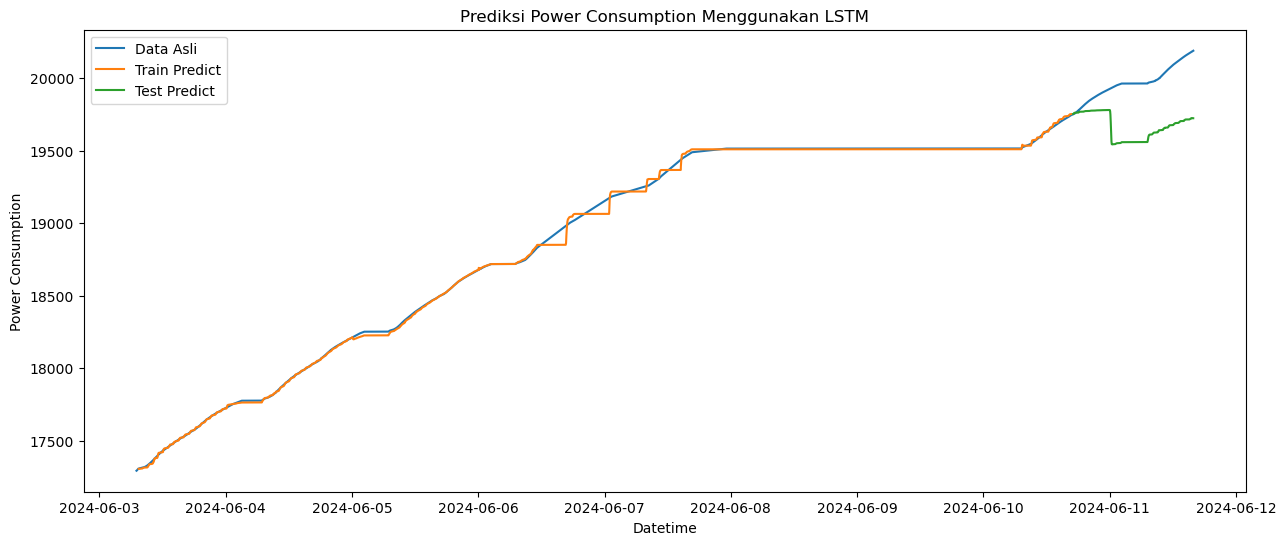

In [49]:
plt.figure(figsize=(15, 6))
plt.plot(data.index, data['PPower Consumption'], label='Data Asli')
train_predict_plot = np.empty_like(scaled_data[:, 0])
train_predict_plot[:] = np.nan
train_predict_plot[look_back:len(train_predict)+look_back] = train_predict

test_predict_plot = np.empty_like(scaled_data[:, 0])
test_predict_plot[:] = np.nan
test_predict_plot[len(train_predict)+(look_back*2)+1:len(scaled_data)-1] = test_predict

plt.plot(data.index, train_predict_plot, label='Train Predict')
plt.plot(data.index, test_predict_plot, label='Test Predict')
plt.xlabel('Datetime')
plt.ylabel('Power Consumption')
plt.title('Prediksi Power Consumption Menggunakan LSTM')
plt.legend()
plt.show()

## Membuat prediksi untuk hari selanjutnya (24 jam ke depan)

In [52]:
last_24_hours = scaled_data[-look_back:]
future_preds = []
current_input = np.reshape(last_24_hours, (1, look_back, X_train.shape[2]))

for i in range(24):
    pred = model.predict(current_input)
    future_preds.append(pred[0, 0])
    current_input = np.append(current_input[:, 1:, :], [[np.append(pred, [current_input[0, -1, 1], current_input[0, -1, 2]])]], axis=1)

future_preds = scaler.inverse_transform(np.concatenate((np.array(future_preds).reshape(-1, 1), np.tile(last_24_hours[-1, 1:], (24, 1))), axis=1))[:, 0]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


### Menyiapkan data untuk visualisasi

In [55]:
future_dates = pd.date_range(start=data.index[-1], periods=25, freq='H')[1:]
future_df = pd.DataFrame({'Datetime': future_dates, 'PPower Consumption': future_preds.flatten()})
future_df['Datetime'] = pd.to_datetime(future_df['Datetime'])
future_df.set_index('Datetime', inplace=True)

C:\Users\asus\AppData\Local\Temp\ipykernel_10616\1958824289.py:1: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  future_dates = pd.date_range(start=data.index[-1], periods=25, freq='H')[1:]


### Visualisasi prediksi dengan pengelompokan LWBP dan WBP

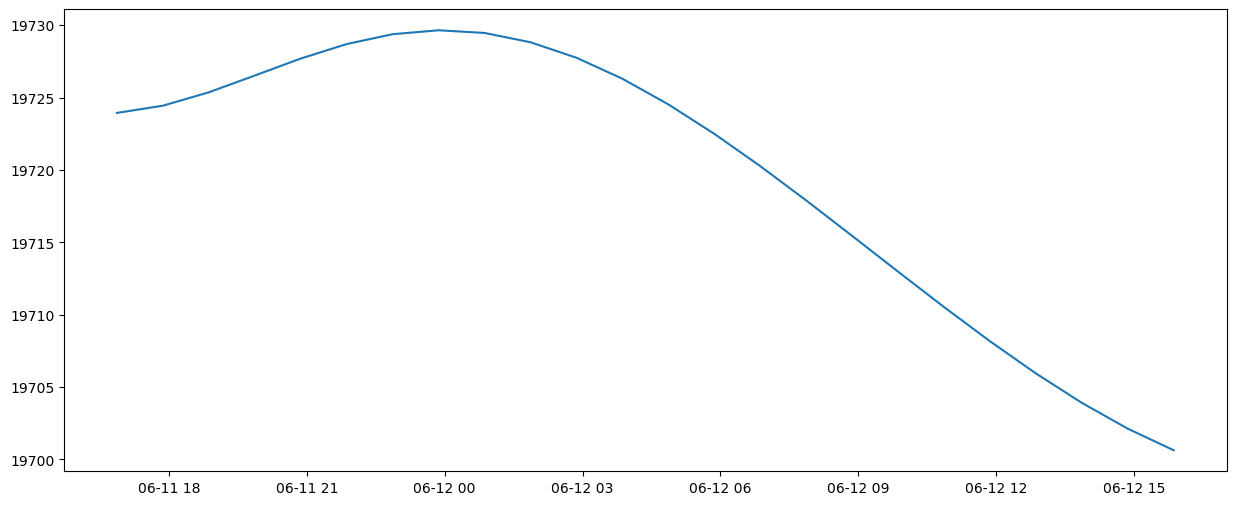

In [58]:
plt.figure(figsize=(15, 6))
plt.plot(future_df.index, future_df['PPower Consumption'], label='Predicted Power Consumption')

## Highlight LWBP dan WBP

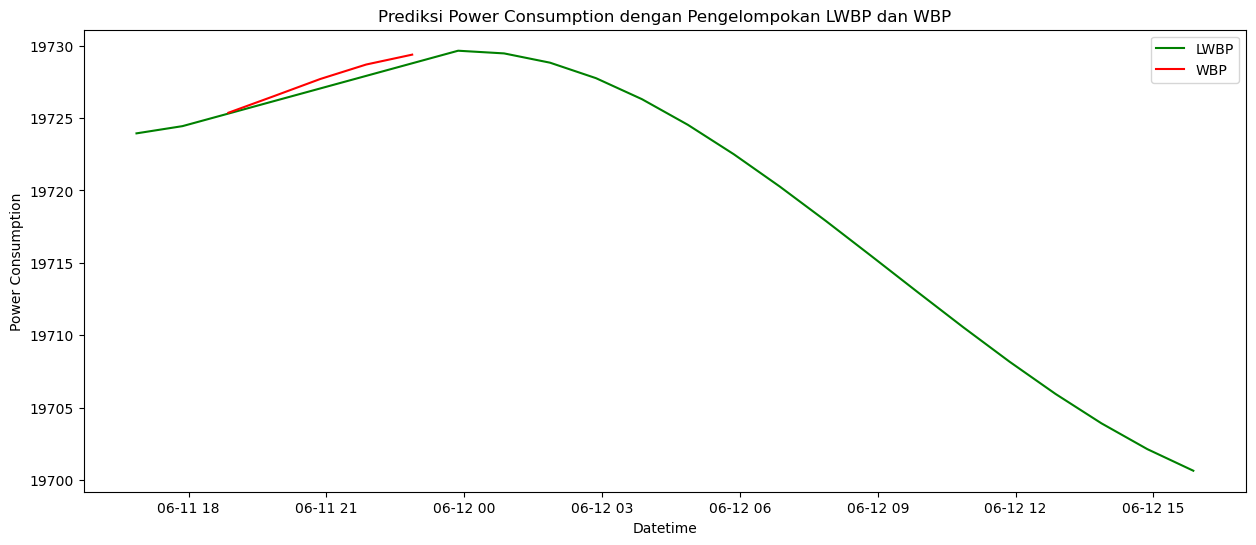

In [69]:
lwbp = future_df.between_time('23:00', '17:59')
wbp = future_df.between_time('18:00', '22:59')

plt.figure(figsize=(15, 6))
plt.plot(lwbp.index, lwbp['PPower Consumption'], 'g', label='LWBP')
plt.plot(wbp.index, wbp['PPower Consumption'], 'r', label='WBP')

plt.xlabel('Datetime')
plt.ylabel('Power Consumption')
plt.title('Prediksi Power Consumption dengan Pengelompokan LWBP dan WBP')
plt.legend()
plt.show()